## 4. Predictive Analysis 

In [1]:
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb

from mlxtend.regressor import StackingRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

# Read data from the data folder
race_df = pd.read_csv('data/race.csv', low_memory=False, index_col=0)
horse_df = pd.read_csv('data/horse.csv', low_memory=False, index_col=0)
individual_df = pd.read_csv('data/individual.csv', low_memory=False, index_col=0)
trainer_df = pd.read_csv('data/trainer.csv', low_memory=False, index_col=0)
jockey_df = pd.read_csv('data/jockey.csv', low_memory=False, index_col=0)
horse_race_df = pd.read_csv('data/horse_race.csv', low_memory=False, index_col=0)
horse_race_df['age_int'] = horse_race_df['sex_age'].apply(lambda x: re.search(r'\d+', x).group(0)).astype(int)

# Do some simple data transformation
horse_race_df['run_date'] = horse_race_df['run_date'].apply(pd.Timestamp)
horse_race_df = horse_race_df.sort_values(['horse_id', 'run_date'])
try:
    first_occur_df = pd.read_csv('data/first_occurence_race.csv', low_memory=False, index_col=0)
    first_occur_df['run_date'] = first_occur_df['run_date'].apply(pd.Timestamp)
    first_occur_df = first_occur_df.sort_values(['horse_id', 'run_date'])
except FileNotFoundError:
    horse_race_sorted = horse_race_df.copy()
    horse_id_set = set()
    first_occur_dict = {}
    for index, value in horse_race_sorted.iterrows():
        if value['horse_id'] not in horse_id_set:
            horse_id_set.add(value['horse_id'])
            first_occur_dict[index] = value
    first_occur_df = pd.DataFrame.from_dict(first_occur_dict, orient='index')
    first_occur_df.to_csv('data/first_occurence_race.csv', encoding='utf-8')
    
columns_to_drop = [
    'race', 'title', 'horse', 'sex_age',
    'distance', 'run_time', 'breeder',
    'jockey', 'margin', 'trainer_x', 'trainer_y', 'owner_x', 'owner_y', 'horse_name', 'date_of_birth', 
    'transaction_price', 'prize_obtained', 'race_record', 'highlight_race', 'relatives', 'status', 'prize'
]
for column in columns_to_drop:
    try:
        first_occur_df.drop(column, axis=1, inplace=True)
        horse_race_df.drop(column, axis=1, inplace=True)
    except ValueError:
        continue
        
horse_df['race_record'] = horse_df['race_record'].apply(lambda x: re.search(r'\[\ (.+)\ \]', x).group(1))
horse_df['race_record'] = horse_df['race_record'].apply(lambda x: list(map(lambda y: int(y), x.split('-'))))
horse_race_df = horse_race_df[horse_race_df['finishing_position'].apply(lambda x: bool(re.search(r'\d+', x)))]
horse_race_df['finishing_position'] = horse_race_df['finishing_position'].apply(lambda x: re.search(r'\d+', x).group(0))
horse_race_df['finishing_position'] = horse_race_df['finishing_position'].astype(int)

C:\Users\terry\Anaconda3\lib\site-packages\cmocean\tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
C:\Users\terry\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 4.1 Feature Engineering 

In [2]:
def cast_individual_id(id_value):
    # Convert id value to the correct form
    try:
        return int(id_value)
    except ValueError:
        return id_value
    
def get_rank_series(rank_series, interval=100):
    # Convert rank series to fit as a dummy variable
    def convert_rank(rank, interval):
        if rank == 0:
            return 'No Data'
        else:
            if rank // interval == 0:
                if rank <= 50:
                    return '1-50'
                else:
                    return '51-99'
            else:
                return '%s-%s' % (int(rank // interval * 100), int(rank // interval * 100 + 100 - 1))
    return rank_series.apply(lambda x: convert_rank(x, interval=interval))
    
def get_dummies_order_by_count(df, column_name):
    # Get dummies by descending count order
    return pd.get_dummies(df[column_name]).reindex(df[column_name].value_counts().index, axis=1).iloc[:, :-1]

def parse_time_stamp(time_string):
    # Parse timestamp expressed in hours
    time_split = time_string.split(':')
    hour = int(time_split[0])
    if hour < 12:
        return '10-12'
    elif hour > 12 and hour < 15:
        return '12-15'
    else:
        return '15-after'
    
def get_trainer_jockey_profile(df, individual):
    # Merge with trainer/jockey dataframe
    assert individual in ['trainer', 'jockey']
    if individual == 'trainer':
        merge_df = trainer_df
    elif individual == 'jockey':
        merge_df = jockey_df
    df = df.merge(merge_df[['%s_id' % individual, 'date_of_birth', 'place_of_birth']], 
                  on='%s_id' % individual, suffixes=['', '_%s' % individual])
    df['run_date'] = df['run_date'].apply(lambda x: pd.Timestamp(x))
    df['date_of_birth'] = df['date_of_birth'].apply(lambda x: pd.Timestamp(x))
    df['%s_age' % individual] = df['run_date'].subtract(df['date_of_birth']).dt.days / 365.0
    df.drop(['date_of_birth'], axis=1, inplace=True)
    top_10_place = df['place_of_birth_%s' % individual].value_counts().index[:10]
    df['place_of_birth_%s' % individual] = df['place_of_birth_%s' % individual].apply(lambda x: x if x in top_10_place \
                                                                                      else 'Others')
    return df

def feature_engineer(race_df, dummy=True, drop_columns=True):
    
    new_df = race_df.copy()

    # Feature engineering
    has_horse_weight = new_df['horse_weight'].apply(lambda x: bool(re.search(r'(\d+)\(.+\)', x)))
    new_df = new_df[has_horse_weight]
    new_df['horse_weight_increase'] = new_df['horse_weight'].apply(lambda x: re.search(r'\(.?(\d+)\)', x).group(1))
    new_df['horse_weight_increase'] = new_df['horse_weight_increase'].astype(float)
    new_df['horse_weight'] = new_df['horse_weight'].apply(lambda x: re.search(r'(\d+)\(.+\)', x).group(1))
    new_df['horse_weight'] = new_df['horse_weight'].astype(float)

    new_df['time'] = new_df['time'].apply(lambda x: parse_time_stamp(x))
    
    top_20_place = new_df['place_of_birth'].value_counts().index[:20]
    new_df['place_of_birth'] = new_df['place_of_birth'].apply(lambda x: x if x in top_20_place else 'Others')
    new_df['age_stated'] = new_df['age_int'].astype(float)
    
    for individual in ['jockey', 'trainer']:
        new_df = get_trainer_jockey_profile(new_df, individual)
        
    # Get individual ranking information
    target_cols = ['rank', 'first', 'second', 'third', 'out', 'races_major', 'wins_major', 'races_special',
                   'wins_special', 'races_flat', 'wins_flat', 'races_grass', 'wins_grass',
                   'races_dirt', 'wins_dirt', 'wins_percent', 'wins_percent_2nd',
                   'wins_percent_3rd']
    individual_column = ['jockey_id', 'owner_id', 'trainer_id', 'breeder_id']
    eng_jap_dict = {'jockey': u'騎手', 'owner': u'馬主', 'trainer': u'調教師', 'breeder': u'生産者'}

    new_df['year_minus_one'] = new_df['run_date'].apply(lambda x: x.year - 1)
    individual_df['individual_id'] = individual_df['individual_id'].apply(lambda x: cast_individual_id(x))

    for col_name in list(filter(lambda x: 'id' in x, new_df.columns)):
        new_df[col_name] = new_df[col_name].apply(lambda x: cast_individual_id(x))

    for col in individual_column:
        new_df = new_df[new_df[col].isin(individual_df.loc[individual_df['individual_type'] == eng_jap_dict[col.split('_')[0]] ,
                                                           'individual_id'])]

    for col in individual_column:
        filtered = individual_df[individual_df['individual_type'] == eng_jap_dict[col.split('_')[0]]]
        original_cols = list(new_df.columns)
        new_df = new_df.merge(filtered, left_on=[col, 'year_minus_one'], right_on=['individual_id', 'year'], 
                              how='left', suffixes=['', col])       
        new_df.fillna(0, inplace=True)
        new_df['rank'] = get_rank_series(new_df['rank'])
        new_df = new_df[original_cols + target_cols]
        new_df.columns = original_cols + list(map(lambda x: x + '_last_year_%s' % col.split('_')[0], target_cols))
        
        rank_col_name = 'rank_last_year_%s' % col.split('_')[0]
        rank_dummy = pd.get_dummies(new_df[rank_col_name]).iloc[:, :-1]
        rank_dummy.columns = list(map(lambda x: 'ranking-%s-%s' % (col.split('_')[0], x), rank_dummy.columns))
        
        new_df = new_df.join(rank_dummy)
        new_df.drop(rank_col_name, axis=1, inplace=True)

    # Get dummy columns
    if dummy:
        dummied_cols = ['place', 'type', 'track', 'weather', 'condition', 'gender', 'breed', 'bracket', 'horse_number', 
                        'time', 'place_of_birth_jockey', 'place_of_birth_trainer', 'place_of_birth']
        for cols in dummied_cols:
            new_df = new_df.join(get_dummies_order_by_count(new_df, 
                                                           cols).rename(columns=lambda x: '-'.join([cols, str(x)])))
            try:
                new_df.drop(cols, axis=1, inplace=True)
            except ValueError:
                continue

    # Drop some other columns
    columns_to_drop_again = ['finishing_position', 'corner_position', 'run_time_last_600', 
                             'jockey_id', 'owner_id', 'trainer_id', 'breeder_id', 
                             'parents', 'age_int']
    if drop_columns:
        for cols in columns_to_drop_again:
            try:
                new_df.drop(cols, axis=1, inplace=True)
            except ValueError:
                continue
    
    return new_df.sort_values(['horse_id', 'run_date']).set_index(['horse_id', 'run_date'])

In [3]:
# TODO: Check parent information (70%+ missing values)

if 1 == 0:
    columns_to_drop_again = ['run_date', 'horse_id', 'parents']
    new_df = first_occur_df[columns_to_drop_again].copy()

    target_columns = ['horse_id', 'date_of_birth', 'breeder_id', 'gender', 'breed', 'race_record']
    new_df['parent_id_1'] = new_df['parents'].apply(lambda x: x.split(' ')[0])
    new_df['parent_id_2'] = new_df['parents'].apply(lambda x: x.split(' ')[1])
    new_df.drop('parents', axis=1, inplace=True)
    new_df = new_df[new_df['parent_id_1'].isin(horse_df['horse_id'].astype(str))]
    new_df = new_df[new_df['parent_id_2'].isin(horse_df['horse_id'].astype(str))]

    new_df.tail()

## 4.2 Regression Analysis

### 4.2.1 OLS for First Occurence Race

In [4]:
new_df_first = feature_engineer(first_occur_df)
X_first = new_df_first.loc[:, new_df_first.columns != 'run_time_1000']
y_first = new_df_first.loc[:, 'run_time_1000']
X_first = sm.add_constant(X_first)
results = sm.OLS(y_first, X_first).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          run_time_1000   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     247.5
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:06:33   Log-Likelihood:            -1.3522e+05
No. Observations:               67877   AIC:                         2.709e+05
Df Residuals:                   67667   BIC:                         2.728e+05
Df Model:                         209                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 27.6812      5.030      5.503      0.000      17.821      37.541
jockey_weight                          0.0788      0.008      9.787      0.000       0.063       0.095
win_odds                               0.0003      0.000      2.069      0.039    1.32e-05       0.000
win_fav                                0.1154      0.003     41.803      0.000       0.110       0.121
horse_weight                           0.0072      0.000     28.365      0.000       0.007       0.008
curr_age                              -0.6282      0.026    -24.384      0.000      -0.679      -0.578
horse_weight_increase                 -0.0492      0.002    -20.738      0.000      -0.054      -0.045
age_stated                             0.3200      0.017     18.387      0.000       0.286       0.354
jockey_age                            -0.0040      0.001     -3.499      0.000      -0.006      -0.002
trainer_age                           -0.0018      0.001     -1.818      0.069      -0.004       0.000
year_minus_one                         0.0163      0.003      6.499      0.000       0.011       0.021
first_last_year_jockey                -0.0128      0.009     -1.366      0.172      -0.031       0.006
second_last_year_jockey                0.0018      0.007      0.267      0.790      -0.011       0.015
third_last_year_jockey                 0.0024      0.007      0.358      0.721      -0.011       0.015
out_last_year_jockey                   0.0034      0.006      0.530      0.596      -0.009       0.016
races_major_last_year_jockey           0.0029      0.007      0.439      0.661      -0.010       0.016
wins_major_last_year_jockey           -0.0063      0.005     -1.283      0.199      -0.016       0.003
races_special_last_year_jockey        -0.0017      0.007     -0.266      0.790      -0.015       0.011
wins_special_last_year_jockey         -0.0049      0.004     -1.269      0.204      -0.012       0.003
races_flat_last_year_jockey           -0.0008      0.007     -0.115      0.909      -0.014       0.012
wins_flat_last_year_jockey            -0.0016      0.004     -0.459      0.646      -0.009       0.005
races_grass_last_year_jockey          -0.0027      0.002     -1.581      0.114      -0.006       0.001
wins_grass_last_year_jockey            0.0204      0.010      2.013      0.044       0.001       0.040
races_dirt_last_year_jockey           -0.0024      0.002     -1.411      0.158      -0.006       0.001
wins_dirt_last_year_jockey             0.0186      0.010      1.845      0.065      -0.001       0.038
wins_percent_last_year_jockey         -0.8626      0.732     -1.178      0.239      -2.298       0.573
wins_percent_2nd_last_year_jockey      0.7289      0.698      1.044      0.296      -0.639      

### 4.2.2 OLS for Full Race

In [5]:
new_df_full = feature_engineer(horse_race_df)
X_full = new_df_full.loc[:, new_df_full.columns != 'run_time_1000']
y_full = new_df_full.loc[:, 'run_time_1000']
X_full = sm.add_constant(X_full)
results = sm.OLS(y_full, X_full).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          run_time_1000   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     4340.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:08:20   Log-Likelihood:            -1.3005e+06
No. Observations:              677627   AIC:                         2.601e+06
Df Residuals:                  677417   BIC:                         2.604e+06
Df Model:                         209                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 68.8892      1.099     62.677      0.000      66.735      71.043
jockey_weight                          0.0205      0.002     11.203      0.000       0.017       0.024
win_odds                               0.0014   3.23e-05     43.404      0.000       0.001       0.001
win_fav                                0.0710      0.001     96.891      0.000       0.070       0.072
horse_weight                           0.0019   7.85e-05     23.941      0.000       0.002       0.002
curr_age                              -0.5944      0.006   -100.763      0.000      -0.606      -0.583
horse_weight_increase                 -0.0092      0.000    -21.543      0.000      -0.010      -0.008
age_stated                             0.2870      0.006     51.122      0.000       0.276       0.298
jockey_age                            -0.0011      0.000     -3.460      0.001      -0.002      -0.000
trainer_age                           -0.0037      0.000    -12.264      0.000      -0.004      -0.003
year_minus_one                        -0.0164      0.001    -22.487      0.000      -0.018      -0.015
first_last_year_jockey                -0.0078      0.003     -2.891      0.004      -0.013      -0.003
second_last_year_jockey               -0.0032      0.002     -1.607      0.108      -0.007       0.001
third_last_year_jockey                -0.0023      0.002     -1.155      0.248      -0.006       0.002
out_last_year_jockey                  -0.0028      0.002     -1.422      0.155      -0.007       0.001
races_major_last_year_jockey           0.0032      0.002      1.612      0.107      -0.001       0.007
wins_major_last_year_jockey           -0.0029      0.001     -1.967      0.049      -0.006   -1.06e-05
races_special_last_year_jockey         0.0035      0.002      1.745      0.081      -0.000       0.007
wins_special_last_year_jockey         -0.0021      0.001     -1.889      0.059      -0.004    7.99e-05
races_flat_last_year_jockey            0.0039      0.002      1.979      0.048    3.73e-05       0.008
wins_flat_last_year_jockey            -0.0028      0.001     -2.710      0.007      -0.005      -0.001
races_grass_last_year_jockey          -0.0008      0.000     -1.848      0.065      -0.002    4.89e-05
wins_grass_last_year_jockey            0.0074      0.003      2.627      0.009       0.002       0.013
races_dirt_last_year_jockey           -0.0013      0.000     -3.062      0.002      -0.002      -0.000
wins_dirt_last_year_jockey             0.0086      0.003      3.085      0.002       0.003       0.014
wins_percent_last_year_jockey          0.0963      0.224      0.429      0.668      -0.343       0.536
wins_percent_2nd_last_year_jockey      0.2979      0.241      1.235      0.217      -0.175      

In [6]:
horse_race_df_grp_by = horse_race_df.set_index(['horse_id', 'run_date'])
horse_race_df_grp_by['run_time_diff'] = horse_race_df_grp_by['run_time_1000'].diff()
horse_race_df_grp_by = horse_race_df_grp_by[~horse_race_df_grp_by.index.isin(first_occur_df.set_index(['horse_id', 
                                                                                                       'run_date']).index)]
horse_race_df_grp_by.reset_index(inplace=True)
new_df_full_diff = feature_engineer(horse_race_df_grp_by)
new_df_full_diff['last_run_time'] = new_df_full_diff['run_time_1000'] - new_df_full_diff['run_time_diff']
new_df_full_diff.drop('run_time_diff', inplace=True, axis=1)

X_full_diff = new_df_full_diff.loc[:, new_df_full_diff.columns != 'run_time_1000']
y_full_diff = new_df_full_diff.loc[:, 'run_time_1000']
X_full_diff = sm.add_constant(X_full_diff)
results_diff = sm.OLS(y_full_diff, X_full_diff).fit()
results_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          run_time_1000   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     5348.
Date:                Thu, 15 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:09:56   Log-Likelihood:            -1.1134e+06
No. Observations:              609756   AIC:                         2.227e+06
Df Residuals:                  609545   BIC:                         2.230e+06
Df Model:                         210                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 52.6417      1.061     49.614      0.000      50.562      54.721
jockey_weight                          0.0085      0.002      4.892      0.000       0.005       0.012
win_odds                               0.0009   3.09e-05     29.304      0.000       0.001       0.001
win_fav                                0.0404      0.001     57.334      0.000       0.039       0.042
horse_weight                          -0.0002   7.62e-05     -2.559      0.010      -0.000   -4.57e-05
curr_age                              -0.2941      0.006    -50.248      0.000      -0.306      -0.283
horse_weight_increase                  0.0020      0.000      4.749      0.000       0.001       0.003
age_stated                             0.1306      0.006     23.332      0.000       0.120       0.142
jockey_age                            -0.0006      0.000     -2.035      0.042      -0.001   -2.37e-05
trainer_age                           -0.0022      0.000     -7.349      0.000      -0.003      -0.002
year_minus_one                        -0.0143      0.001    -20.316      0.000      -0.016      -0.013
first_last_year_jockey                -0.0051      0.003     -1.955      0.051      -0.010    1.24e-05
second_last_year_jockey               -0.0025      0.002     -1.279      0.201      -0.006       0.001
third_last_year_jockey                -0.0014      0.002     -0.749      0.454      -0.005       0.002
out_last_year_jockey                  -0.0022      0.002     -1.152      0.249      -0.006       0.002
races_major_last_year_jockey           0.0015      0.002      0.778      0.437      -0.002       0.005
wins_major_last_year_jockey           -0.0024      0.001     -1.708      0.088      -0.005       0.000
races_special_last_year_jockey         0.0026      0.002      1.381      0.167      -0.001       0.006
wins_special_last_year_jockey         -0.0008      0.001     -0.753      0.452      -0.003       0.001
races_flat_last_year_jockey            0.0027      0.002      1.392      0.164      -0.001       0.006
wins_flat_last_year_jockey            -0.0019      0.001     -1.863      0.062      -0.004    9.71e-05
races_grass_last_year_jockey          -0.0002      0.000     -0.510      0.610      -0.001       0.001
wins_grass_last_year_jockey            0.0040      0.003      1.476      0.140      -0.001       0.009
races_dirt_last_year_jockey           -0.0008      0.000     -2.024      0.043      -0.002   -2.66e-05
wins_dirt_last_year_jockey             0.0054      0.003      2.020      0.043       0.000       0.011
wins_percent_last_year_jockey          0.2208      0.217      1.020      0.308      -0.204       0.645
wins_percent_2nd_last_year_jockey      0.2134      0.237      0.900      0.368      -0.251      

## 4.3 Regression Models

In [7]:
max_window = 3
try:
    df_combined = pd.read_csv('data/horse_race_combined.csv', low_memory=False, index_col=0)
    df_combined['run_date'] = df_combined['run_date'].apply(lambda x: pd.Timestamp(x))
    df_combined = df_combined.sort_values(['horse_id', 'run_date'])
    
    df_combined = df_combined.iloc[:50000]
    
    df_combined.set_index(['horse_id', 'run_date'], inplace=True)
    df_combined = df_combined[~df_combined.index.isin(first_occur_df.sort_values(['horse_id', 'run_date']).set_index(['horse_id', 'run_date']).index)]
except FileNotFoundError:
    df_combined = horse_race_df.set_index(['horse_id', 'run_date'])
    df_combined['run_time_diff'] = df_combined['run_time_1000'].diff()
    df_combined['last_run_time'] = df_combined['run_time_1000'] - df_combined['run_time_diff']
    df_combined['run_time_quo'] = df_combined['run_time_1000'] / df_combined['last_run_time']
    df_combined['run_time_mean'] = df_combined['last_run_time']

    df_reset = df_combined['run_time_mean'].reset_index()
    horse_id_lst = list(df_reset['horse_id'])
    run_time_mean_lst = list(df_reset['run_time_mean'])
    new_run_time_mean_lst = []
    new_run_time_median_lst = []
    curr_index = horse_id_lst[0]
    curr_count = 0
    curr_sum = 0
    curr_stored = []
    for index, value in zip(horse_id_lst, run_time_mean_lst):
        if index != curr_index:
            curr_count = 1
            curr_sum = value
            curr_index = index
            curr_stored = [value]
        else:
            curr_count += 1
            curr_sum += value
            curr_stored.append(value)
        new_run_time_mean_lst.append(curr_sum / (curr_count * 1.0))
        new_run_time_median_lst.append(np.median(curr_stored))
    df_combined['run_time_mean'] = pd.Series(new_run_time_mean_lst, index=df_combined.index)
    df_combined['run_time_median'] = pd.Series(new_run_time_median_lst, index=df_combined.index)

    for window in range(2, max_window + 1):
        ma = df_combined.groupby(level=0)['run_time_1000'].rolling(window).mean().groupby(level=0).shift(1)
        ma = ma.reset_index(level=1)['run_time_1000'].reset_index()
        ewma = df_combined.groupby(level=0)['run_time_1000'].apply(lambda series: series.ewm(ignore_na=True, 
                                                                                             min_periods=window, 
                                                                                             adjust=True,
                                                                                             com=0.030927835051546).mean())
        ewma = ewma.groupby(level=0).shift(1)
        df_combined['run_time_ma_window_%s' % str(window)] = ma.set_index(['horse_id', 'run_date'])['run_time_1000']
        df_combined['run_time_ewma_window_%s' % str(window)] = ewma
    df_combined.reset_index().to_csv('data/horse_race_combined.csv', encoding='utf-8')

dependent = ['run_time_1000',
             'run_time_diff', 'run_time_quo', 
             'run_time_mean', 'run_time_median'] + \
            ['run_time_ma_window_%s' % str(idx) for idx in range(2, max_window + 1)] + \
            ['run_time_ewma_window_%s' % str(idx) for idx in range(2, max_window + 1)]
df_combined_y = df_combined[dependent].copy()
df_combined_x = df_combined[list(filter(lambda x: x not in dependent, df_combined.columns))].copy()
df_y_original_dict = {}
df_y_original_dict['run_time_diff'] = df_combined_x['last_run_time']
df_y_original_dict['run_time_quo'] = df_combined_x['last_run_time']
for col_name in dependent[3:]:
    df_combined_y[col_name + '_diff'] = df_combined_y['run_time_1000'] - df_combined_y[col_name]
    df_combined_y[col_name + '_quo'] = df_combined_y['run_time_1000'] / df_combined_y[col_name]
    df_y_original_dict[col_name + '_diff'] = df_combined_y[col_name]
    df_y_original_dict[col_name + '_quo'] = df_combined_y[col_name]
    df_combined_y.drop(col_name, axis=1, inplace=True)

In [8]:
df_combined_y[list(filter(lambda x: 'diff' in x or 'quo' in x, df_combined_y.columns))].T

horse_id                             1986102130          1989107128  \
run_date                    2000-01-29 15:40:00 2000-02-05 13:45:00   
run_time_diff                          1.642857           -1.146258   
run_time_quo                           1.027381            0.983224   
run_time_mean_diff                          NaN            2.547192   
run_time_mean_quo                           NaN            1.039409   
run_time_median_diff                        NaN            2.547192   
run_time_median_quo                         NaN            1.039409   
run_time_ma_window_2_diff                   NaN                 NaN   
run_time_ma_window_2_quo                    NaN                 NaN   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN                 NaN   
run_time_ewma_window_2_quo                  NaN                 NaN   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                                                             \
run_date                    2000-03-11 15:10:00 2000-04-15 15:30:00   
run_time_diff                          0.510490            2.697936   
run_time_quo                           1.007599            1.039856   
run_time_mean_diff                     2.208618            4.354399   
run_time_mean_quo                      1.033728            1.065940   
run_time_median_diff                   0.510490            2.953181   
run_time_median_quo                    1.007599            1.043792   
run_time_ma_window_2_diff             -0.062639            2.953181   
run_time_ma_window_2_quo               0.999076            1.043792   
run_time_ma_window_3_diff                   NaN            2.656177   
run_time_ma_window_3_quo                    NaN            1.039215   
run_time_ewma_window_2_diff            0.477103            2.712237   
run_time_ewma_window_2_quo             1.007098            1.040076   
run_time_ewma_window_3_diff                 NaN            2.712237   
run_time_ewma_window_3_quo                  NaN            1.040076   

horse_id                             1990104469                      \
run_date                    2000-03-18 11:45:00 2000-04-15 15:30:00   
run_time_diff                          1.279356            1.830030   
run_time_quo                           1.019112            1.026826   
run_time_mean_diff                    -0.446069            1.532651   
run_time_mean_quo                      0.993504            1.022369   
run_time_median_diff                  -0.446069            1.830030   
run_time_median_quo                    0.993504            1.026826   
run_time_ma_window_2_diff                   NaN            2.469709   
run_time_ma_window_2_quo                    NaN            1.036545   
run_time_ma_window_3_diff                   NaN                 NaN   
run_time_ma_window_3_quo                    NaN                 NaN   
run_time_ewma_window_2_diff                 NaN            1.867293   
run_time_ewma_window_2_quo                  NaN            1.027387   
run_time_ewma_window_3_diff                 NaN                 NaN   
run_time_ewma_window_3_quo                  NaN                 NaN   

horse_id                             1991100019                      \
run_date                    2000-02-12 15:45:00 2000-03-19 15:00:00   
run_time_diff                          0.214286           -1.160714   
run_time_quo                           1.003567            0.980746   
run_time_mean_diff                    -4.396341           -4.091609   
run_time_mean_quo                      0.932032            0.935276   
run_time_median_diff                  -4.396341           -1.160714   
run_time_median_quo                    0.932032            0.980746   
run_time_ma_window_2_

In [9]:
# Model testing for run time residual
x = feature_engineer(df_combined_x.reset_index())
x = x.drop('last_run_time', axis=1)
y = df_combined_y.loc[df_combined_y.index.isin(x.index), 'run_time_diff']

# OLS
reg = linear_model.LinearRegression(fit_intercept=False)
scores_reg = cross_val_score(reg, x, y, scoring='neg_mean_squared_error')
print("RMSE for OLS: %0.5f" % np.sqrt(-scores_reg.mean()))

RMSE for OLS: 1.98439


In [10]:
class ModelComparer(object): 
    
    no_drop_col = ['run_time_1000']
    
    def __init__(self, X_df, y_df, original_y_df_dict):
        self.X = feature_engineer(X_df.reset_index())
        self.y = y_df[y_df.index.isin(self.X.index)]
        self.y_original = original_y_df_dict
        self.run_time_serie = self.y['run_time_1000']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3)
        self.model_dict = {}
        self.models = []
        
    def add_model(self, model_method, model_name):
        
        print('Adding model named %s ' % model_name)
        self.model_dict[model_name] = {}
        self.models.append(model_method)
        
        for y_col_name in self.y.columns:
            X_train = self.X_train.copy()
            X_test = self.X_test.copy()                
            model = model_method
            self.model_dict[model_name]['Model Spec'] = repr(model)
            
            if y_col_name not in self.no_drop_col:
                X_train.drop('last_run_time', axis=1, inplace=True)
                X_test.drop('last_run_time', axis=1, inplace=True)
                
            y_train = self.y_train[y_col_name].dropna()
            y_test = self.y_test[y_col_name].dropna()
            
            X_train = X_train[X_train.index.isin(y_train.index)]
            X_test = X_test[X_test.index.isin(y_test.index)]
                     
            if 'normalized' in model_name.lower():
                scaler = StandardScaler()
                scaler.fit(X_train)
                X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index)
                X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
            
            print('Performing analysis on column %s for model %s (Size: %s)' % (y_col_name, model_name, str(X_train.shape)))
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            if y_col_name not in self.no_drop_col:
                y_pred = pd.Series(y_pred, index=X_test.index)
                original_serie = df_y_original_dict[y_col_name]
                original_serie = original_serie[original_serie.index.isin(y_pred.index)]
                run_time_serie = self.run_time_serie[self.run_time_serie.index.isin(y_pred.index)]
                if 'quo' in y_col_name:
                    y_pred = y_pred * original_serie
                elif 'diff' in y_col_name:
                    y_pred = y_pred + original_serie
                self.model_dict[model_name]['Transformed RMSE: %s (%s)' % (y_col_name, 
                                                                           X_train.shape[0])] = '%.6f' % self.get_rmse(y_pred, 
                                                                                                                       run_time_serie) 
                self.model_dict[model_name]['Transformed R^2: %s (%s)' % (y_col_name, 
                                                                          X_train.shape[0])] = '%.3f' % self.get_r_squared(y_pred, 
                                                                                                                           run_time_serie)
            else:
                self.model_dict[model_name]['Original RMSE: %s (%s)' % (y_col_name, 
                                                                        X_train.shape[0])] = '%.6f' % self.get_rmse(y_pred, 
                                                                                                                    y_test)
                self.model_dict[model_name]['Original R^2: %s (%s)' % (y_col_name, 
                                                                       X_train.shape[0])] = '%.3f' % self.get_r_squared(y_pred, 
                                                                                                                        y_test)
        
    def get_report(self, filter_word=''):
        try:
            df = pd.DataFrame.from_dict(self.model_dict)
            return df.loc[list(filter(lambda x: filter_word in x, df.index))].sort_values(df.columns[0])
        except IndexError:
            return
    
    @staticmethod
    def get_rmse(y_true, y_pred):
        diff = np.sum((y_true - y_pred) ** 2)
        return (diff / y_true.shape[0]) ** 1/2
    
    @staticmethod
    def get_r_squared(y_true, y_pred):
        return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    
mc = ModelComparer(df_combined_x, df_combined_y, df_y_original_dict)

In [11]:
def get_ols(**kwargs):
    reg = linear_model.LinearRegression(**kwargs)
    return reg

def get_xgboost(**kwargs):
    xgb_model = xgb.XGBRegressor(**kwargs)
    return xgb_model

def get_decision_tree(**kwargs):
    dt = DecisionTreeRegressor(**kwargs)
    return dt

def get_random_forest(**kwargs):
    regr = RandomForestRegressor(**kwargs)
    return regr

def get_gbm(**kwargs):
    clf = GradientBoostingRegressor(**kwargs)
    return clf

def get_ann(**kwargs):
    mlp = MLPRegressor(**kwargs)
    return mlp

def get_meta_learner(**kwargs):
    stregr = StackingRegressor(**kwargs)
    return stregr

# Add base model
mc.add_model(get_ols(fit_intercept=False), 'OLS - Base Model')
mc.add_model(get_xgboost(learning_rate=0.1), 'XGB - Base Model (0.1LR)')
mc.add_model(get_decision_tree(max_depth=6), 'DT - Base Model (6MD)')
mc.add_model(get_random_forest(max_depth=6), 'RF - Base Model (6MD)')
mc.add_model(get_gbm(n_estimators=500, max_depth=6, min_samples_split=2, learning_rate=0.1, loss='ls'), 'GBM - Base Model (6MD, 0.1LR)')
mc.add_model(get_ann(max_iter=100000, learning_rate_init=0.02, hidden_layer_sizes=(300, 300, 300)), 'ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL)')

# Stacking
ols_base = get_ols(fit_intercept=False)
xgb_base = get_xgboost(learning_rate=0.1)
dt_base = get_decision_tree(max_depth=6)
rf_base = get_random_forest(max_depth=6)
gbm_base = get_gbm(n_estimators=500, max_depth=6, min_samples_split=2, learning_rate=0.1, loss='ls')
ann_base = get_ann(max_iter=100000, learning_rate_init=0.02, hidden_layer_sizes=(300, 300, 300))
xgb_meta = get_xgboost(learning_rate=0.1)
mc.add_model(get_meta_learner(regressors=[ols_base, xgb_base, dt_base, rf_base, gbm_base, ann_base], meta_regressor=xgb_meta), 'Meta - XGB (0.1LR)')

Adding model named OLS - Base Model 
Performing analysis on column run_time_1000 for model OLS - Base Model (Size: (29976, 215))
Performing analysis on column run_time_diff for model OLS - Base Model (Size: (29976, 214))
Performing analysis on column run_time_quo for model OLS - Base Model (Size: (29976, 214))
Performing analysis on column run_time_mean_diff for model OLS - Base Model (Size: (29975, 214))
Performing analysis on column run_time_mean_quo for model OLS - Base Model (Size: (29975, 214))
Performing analysis on column run_time_median_diff for model OLS - Base Model (Size: (29975, 214))
Performing analysis on column run_time_median_quo for model OLS - Base Model (Size: (29975, 214))
Performing analysis on column run_time_ma_window_2_diff for model OLS - Base Model (Size: (27171, 214))
Performing analysis on column run_time_ma_window_2_quo for model OLS - Base Model (Size: (27171, 214))
Performing analysis on column run_time_ma_window_3_diff for model OLS - Base Model (Size: (

Performing analysis on column run_time_1000 for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (29976, 215))
Performing analysis on column run_time_diff for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (29976, 214))
Performing analysis on column run_time_quo for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (29976, 214))
Performing analysis on column run_time_mean_diff for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (29975, 214))
Performing analysis on column run_time_mean_quo for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (29975, 214))
Performing analysis on column run_time_median_diff for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (29975, 214))
Performing analysis on column run_time_median_quo for model ANN - Base Model (normalized, 100000MI, 0.02LR, 300**3HL) (Size: (29975, 214))
Performing analysis on column run_time_ma_window

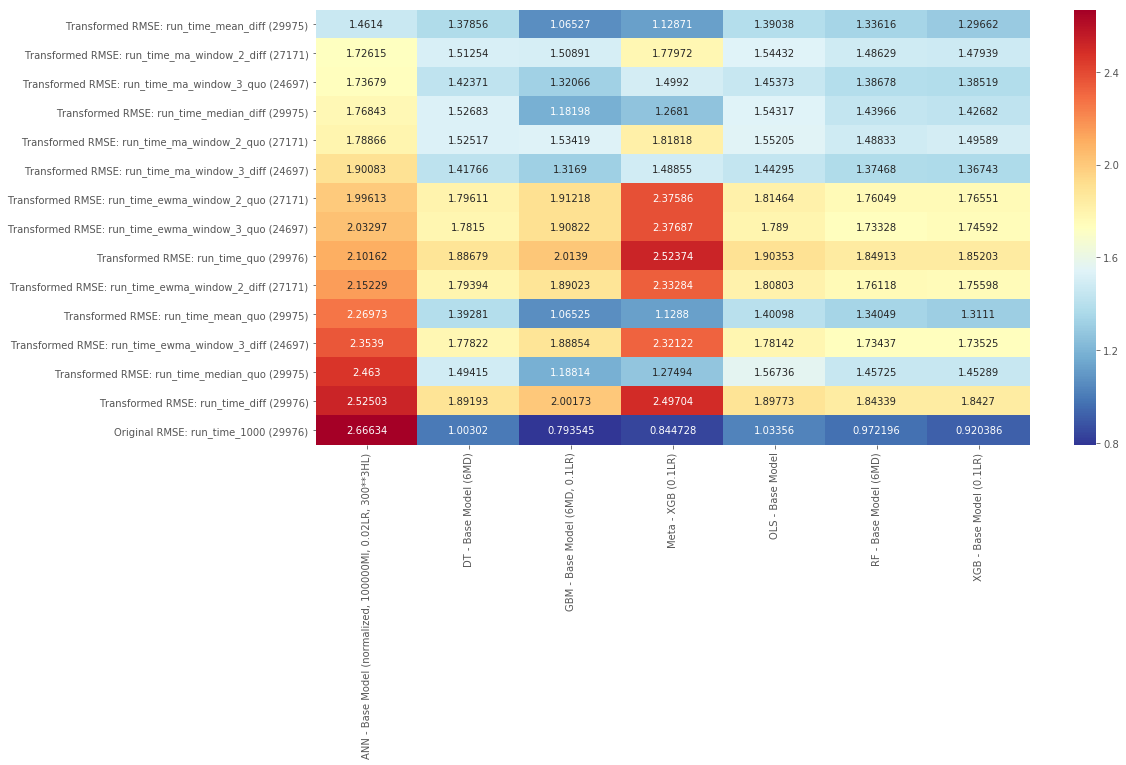

In [18]:
# Set some specs for plotting
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.style.use('ggplot')

value_df = mc.get_report(filter_word='RMSE').dropna().iloc[:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap='RdYlBu_r')

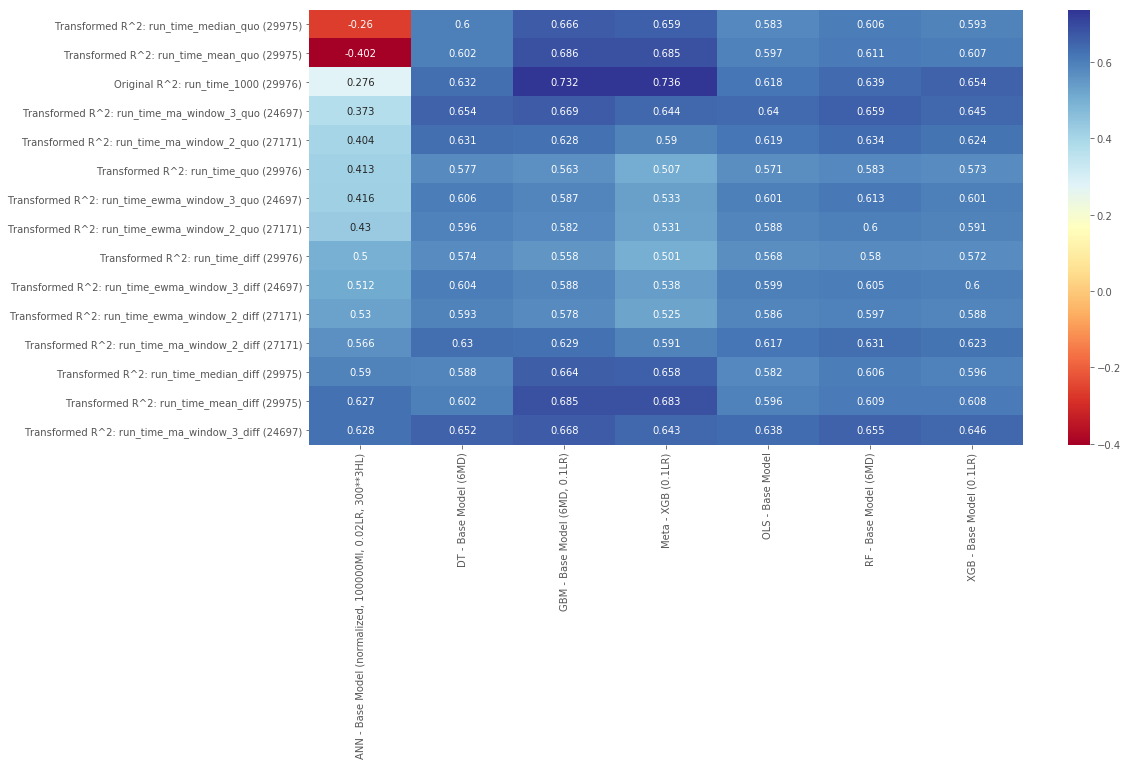

In [19]:
value_df = mc.get_report(filter_word='R^2').dropna().iloc[:, :]
value_df = value_df.applymap(lambda x: float(x))
sns.heatmap(value_df, annot=True, fmt='g', cmap='RdYlBu')